In [11]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pymf.model as model
import pymf.solvers as solvers
import pymf.mf as mf
import pymf.tb as tb
import pymf.observables as observables
import pymf.kwant_helper.kwant_examples as kwant_examples
import pymf.kwant_helper.utils as kwant_utils

In [2]:
graphene_builder, int_builder = kwant_examples.graphene_extended_hubbard()
h_0 = kwant_utils.builder_to_tb(graphene_builder)

In [86]:
U=4
V=0
params = dict(U=U, V=V)
h_int = kwant_utils.builder_to_tb(int_builder, params)
_model = model.Model(h_0, h_int, filling=2)
guess = tb.utils.generate_guess(frozenset(h_int), len(list(h_0.values())[0]))
mf_sol = solvers.solver(_model, guess, nk=18, optimizer_kwargs={'M':0})
full_sol = tb.tb.add_tb(h_0, mf_sol)

In [87]:
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]])

s_list = [sx, sy, sz]
rho, _ = mf.construct_density_matrix(full_sol, filling=2, nk=40)

order_parameter_list = []
for s in s_list: 
    order_parameter = {}
    order_parameter[(0,0)] =  np.kron(sz, s)
    order_parameter_list.append(order_parameter)

expectation_value_list = []
for order_parameter in order_parameter_list:
    expectation_value = observables.expectation_value(rho, order_parameter)
    expectation_value_list.append(expectation_value)

In [88]:
np.sum(np.array(expectation_value_list)**2)

(1.804655008699922+0j)

In [64]:
#antiferromagnetic order parameter
anti_order_parameter = {}
anti_order_parameter[(0,0)] = np.kron(sz, sz)
expectation_value = observables.expectation_value(rho, anti_order_parameter)

In [54]:

cdw_order_parameter = {}
cdw_order_parameter[(0,0)] = np.kron(sz, np.eye(2))


sdw_order_parameter = {}
sdw_order_parameter[(0,0)] = np.kron(np.eye(2), sz)

In [55]:
expectation_value = observables.expectation_value(rho, cdw_order_parameter)

In [56]:
expectation_value

(-1.5833996732759665+0j)

In [4]:
h_0

{(0,
  0): array([[0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.]]),
 (0,
  -1): array([[0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 (0,
  1): array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.]]),
 (1,
  -1): array([[0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 (-1,
  1): array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.]])}

In [ ]:
def compute_gap(h, fermi_energy=0, nk=100):
    kham = tb.transforms.tb_to_khamvector(h, nk, ks=None)
    vals = np.linalg.eigvalsh(kham)

    emax = np.max(vals[vals <= fermi_energy])
    emin = np.min(vals[vals > fermi_energy])
    return np.abs(emin - emax)

In [ ]:
def compute_phase_diagram(Us, Vs, int_builder, h_0): 
    gap = []
    for U in Us: 
      for V in Vs: 
        params = dict(U=U, V=V)
        h_int = kwant_utils.builder_to_tb(int_builder, params)
        _model = model.Model(h_0, h_int, filling=2)

        converged=False
        while not converged:
          guess = tb.utils.generate_guess(frozenset(h_int), len(list(h_0.values())[0]))
          try:
            mf_sol = solvers.solver(_model, guess, nk=18, optimizer_kwargs={'M':0})
            converged=True
          except:
            converged=False
        gap.append(compute_gap(tb.tb.add_tb(h_0, mf_sol), fermi_energy=0, nk=300))
      guess = None
    return np.asarray(gap, dtype=float).reshape(len(Us), len(Vs))

In [9]:
Us = np.linspace(0, 3, 10, endpoint=True)
Vs = np.linspace(0, 1.5, 10, endpoint=True)
gap = compute_phase_diagram(Us, Vs, int_builder, h_0)

100%|██████████| 10/10 [07:09<00:00, 43.00s/it]


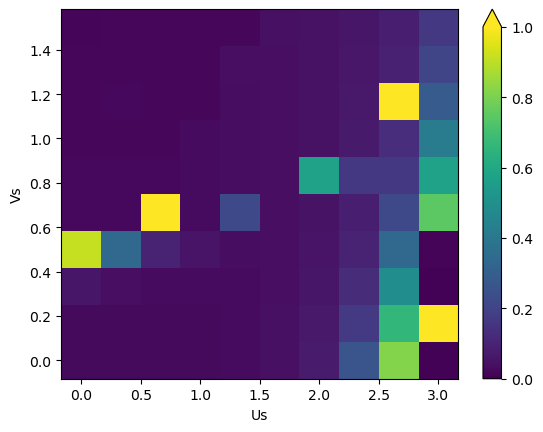

In [11]:
gap_da = xr.DataArray(data=gap, coords=dict(Us=Us, Vs=Vs))
gap_da.plot(x="Us", y="Vs", vmin=0, vmax=1)

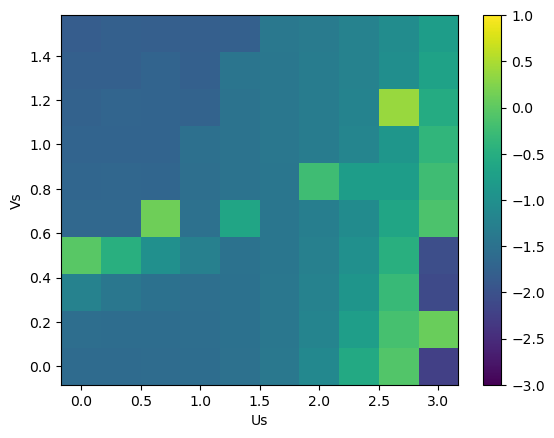

In [12]:
np.log10(gap_da).plot(x="Us", y="Vs", vmin=-3, vmax=1) 

0.02672641009348376

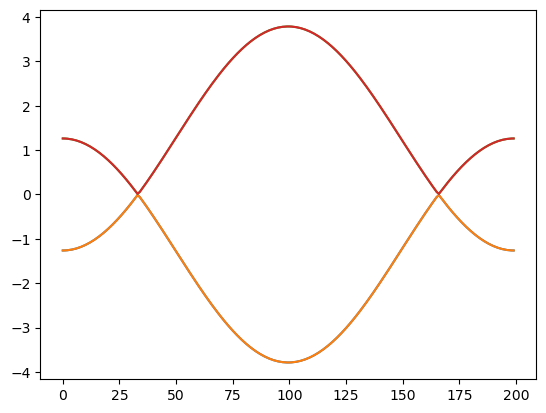

In [37]:
#Single shot calculation
params = dict(U=0, V=1)
filling = 2 

h_int = utils.builder_to_tb(int_builder, params)
model = Model(h_0, h_int, filling)
mf_guess = utils.generate_guess(frozenset(h_int), len(list(h_0.values())[0]))
mf_sol = solver(model, mf_guess, nK=30)

ks = np.linspace(-np.pi, np.pi, 200)
hkfunc = tb2kfunc(addTb(h_0, mf_sol))
hkarray = np.array([hkfunc((kx, -kx)) for kx in ks])
vals = np.linalg.eigvalsh(hkarray)
plt.plot(vals)
utils.calc_gap(vals, E_F=0)

In [2]:

import numpy as np
from codes.model import Model
from codes import kwant_examples
from codes.kwant_helper import utils
import timeit
import memray




In [3]:
graphene_builder, int_builder = kwant_examples.graphene_extended_hubbard()

params = {"U": 0.5, "V": 1.1}
filling = 2
nK = 300

h_int = utils.builder_to_tb(int_builder, params)
h_0 = utils.builder_to_tb(graphene_builder)
guess = utils.generate_guess(frozenset(h_int), len(list(h_0.values())[0]))

model = Model(h_0, h_int, filling)


def scf_loop():
    model.mfield(guess, nK=nK)


# %% Memory profile
with memray.Tracker("memoryProfile.bin"):
    scf_loop()




Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
# %% Time profiler
profiler = Profiler()

profiler.start()
scf_loop()
profiler.stop()
profiler.write_html(path="timeProfile.html")



In [5]:
# %%
number = 1

timeSCF = timeit.timeit(scf_loop, number=number) / number

H = np.random.rand(nK, nK)
H += H.T.conj()
timeDiag = timeit.timeit(lambda: np.linalg.eigh(H), number=number) / number

print(
    f"Single SCF loop takes {timeSCF} whereas a single diagonalization of a corresponding system takes {timeDiag}"
)

Single SCF loop takes 7.120591291008168 whereas a single diagonalization of a corresponding system takes 0.024635875000967644
